In [1]:
import torch, os, math
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline

In [2]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3070 Ti Laptop GPU', major=8, minor=6, total_memory=8191MB, multi_processor_count=46)

In [3]:
img = io.read_image('puppy.jpg')
img_grey_gs = (0.2989*img[0,:,:] + 0.5870*img[1,:,:] + 0.1140*img[2,:,:]).type(torch.uint8)

In [4]:
def assert_equal(img_1, img_2, atol = 1):
    assert torch.isclose(img_1,img_2, atol=atol).all()

In [5]:
def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

In [6]:
%load_ext wurlitzer

In [7]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

In [8]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

In [9]:
cuda_src = cuda_begin + r'''
#include <cub/block/block_load.cuh>
#include <cub/block/block_store.cuh>

template<typename T>
__device__ unsigned char rgb_to_gray(const unsigned char r, const unsigned char g, const unsigned char b){
    return static_cast<T>(0.2989)*r +  static_cast<T>(0.5870)*g + static_cast<T>(0.1140)*b;
}

template<typename T>
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) out[i] = rgb_to_gray<T>(x[i], x[i+n], x[i+2*n]);
}

__global__ void rgb_to_grayscale_kernel_int(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) out[i] = ((77*x[i] + 150*x[i+n] + 29*x[i+2*n]) >> 8);
}

template<typename T>
__device__ void rgb_to_gray(const unsigned int rVec, const unsigned int gVec, const unsigned int bVec, unsigned int* greyVec){
    unsigned char* grey = (unsigned char*)greyVec;
    for (int i = 0; i < 4; i++) {
        const unsigned char r = ((const unsigned char*)&rVec)[i];
        const unsigned char g = ((const unsigned char*)&gVec)[i];
        const unsigned char b = ((const unsigned char*)&bVec)[i];
        grey[i] = rgb_to_gray<T>(r,g,b);
    }
}

// coalesced read/write - example implementation without handler for unaligned memory or width which is not divisible by 4
template<typename T>
__global__ void rgb_to_grayscale_kernel_coalesced(unsigned char* x, unsigned char* out, int n) {
    int idx = blockIdx.x*blockDim.x + threadIdx.x;
    if(idx>n) return;
    unsigned int *xUint = (unsigned int*)x;
    const unsigned int r = xUint[idx];
    const unsigned int g = xUint[idx+n];
    const unsigned int b = xUint[idx+2*n];
    unsigned int gray;
    rgb_to_gray<T>(r,g,b, &gray);
    unsigned int *outUint = (unsigned int*)out;
    outUint[idx] =  gray;
}

// vectorized coalesced read/write, no computation baseline
__global__ void rgb_to_r(unsigned char* x, unsigned char* out, int n) {
    int idx = blockIdx.x*blockDim.x + threadIdx.x;
    if(idx > n) return;
    uint2 *inUint2 = (uint2*)x;
    uint2 *outUint2 = (uint2*)out;
    outUint2[idx] = inUint2[idx];
}

// vectorized coalesced read/write -  no safety checking
template<typename T>
__global__ void rgb_to_grayscale_kernel_coalesced_uint2(unsigned char* x, unsigned char* out, int n) {
    int idx = blockIdx.x*blockDim.x + threadIdx.x;
    if(idx > n) return;
    uint2 *xUint = (uint2*)x;
    uint2 greyVec;
    rgb_to_gray<T>(xUint[idx].x, xUint[idx+n].x, xUint[idx+2*n].x, &greyVec.x);
    rgb_to_gray<T>(xUint[idx].y, xUint[idx+n].y, xUint[idx+2*n].y, &greyVec.y);
    uint2 *outUint = (uint2*)out;
    outUint[idx] = greyVec;
}

// cub load/store - no safety checking
template<typename T, int BLOCK_THREADS, int ITEMS_PER_THREAD>
__global__ void rgb_to_grayscale_cub(unsigned char* x, unsigned char* out, int n) {
    enum { TILE_SIZE = BLOCK_THREADS * ITEMS_PER_THREAD };
    typedef cub::BlockLoad<unsigned char, BLOCK_THREADS, ITEMS_PER_THREAD, cub::BLOCK_LOAD_VECTORIZE > BlockLoad;
    typedef cub::BlockStore<unsigned char, BLOCK_THREADS, ITEMS_PER_THREAD, cub::BLOCK_STORE_VECTORIZE> BlockStore;
    __shared__ union TempStorage
    {
        typename BlockLoad::TempStorage    load;
        typename BlockStore::TempStorage   store;
    } temp_storage;

    unsigned char r[ITEMS_PER_THREAD];
    unsigned char g[ITEMS_PER_THREAD];
    unsigned char b[ITEMS_PER_THREAD];
    unsigned char grey[ITEMS_PER_THREAD];
    const int blockOffset = blockIdx.x * TILE_SIZE;
    BlockLoad(temp_storage.load).Load(x + blockOffset, r);
    BlockLoad(temp_storage.load).Load(x + blockOffset + n, g);
    BlockLoad(temp_storage.load).Load(x + blockOffset + 2*n, b);

    for(int i = 0; i < ITEMS_PER_THREAD; i++)
        grey[i] = rgb_to_gray<T>(r[i],g[i],b[i]);

    BlockStore(temp_storage.store).Store(out + blockOffset, grey);
}

void rgb_to_grayscale(torch::Tensor input, torch::Tensor output, int approach, bool internalTimer) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    constexpr int threads = 256;
    cudaEvent_t start, end;
    if(internalTimer){ 
        cudaEventCreate(&start);
        cudaEventCreate(&end);
        cudaEventRecord(start);
    }
    switch(approach){
    case 0:
        rgb_to_grayscale_kernel<double><<<cdiv(w*h,threads), threads>>>(
            input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
        break;
    case 1:
        rgb_to_grayscale_kernel<float><<<cdiv(w*h,threads), threads>>>(
            input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
        break;
    case 2:
        rgb_to_grayscale_kernel_int<<<cdiv(w*h,threads), threads>>>(
            input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
        break;
    case 3:
        rgb_to_grayscale_kernel_coalesced<float><<<cdiv(w/4*h,threads), threads>>>(
            input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w/4*h);
            break;
    case 4:
        rgb_to_grayscale_kernel_coalesced_uint2<float><<<cdiv(w/8*h,threads), threads>>>(
            input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w/8*h);
            break;
    case 5:
        rgb_to_r<<<cdiv(w/8*h,threads), threads>>>(
            input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w/8*h);
            break;
    case 6:
        rgb_to_grayscale_cub<float, threads,8><<<cdiv(w*h/8,threads), threads>>>(
            input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
        }
            
    if(internalTimer){
        cudaEventRecord(end);
        cudaEventSynchronize(end);
        float ms;
        cudaEventElapsedTime(&ms, start, end);
        printf("elTime (ns): %.2f\n", ms*1000);        
        cudaEventDestroy(start);
        cudaEventDestroy(end);
    }
}'''

In [10]:
cpp_src = "void rgb_to_grayscale(torch::Tensor input, torch::Tensor output, int approach, bool internalTimer);"

In [11]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True)

Using /home/b/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/b/.cache/torch_extensions/py311_cu121/inline_ext/build.ninja...
Building extension module inline_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module inline_ext...


In [12]:
[o for o in dir(module) if o[0]!='_']

['rgb_to_grayscale']

In [13]:
imgc = img.contiguous().cuda()
img_grey = torch.zeros((imgc.size(1),imgc.size(2)), dtype=torch.uint8).cuda() # ensure new return image after each run

### Double

In [14]:
img_grey.zero_()
for i in range(1000): module.rgb_to_grayscale(imgc, img_grey, 0, False)
for i in range(10): module.rgb_to_grayscale(imgc, img_grey, 0, True)
assert_equal(img_grey_gs, img_grey.cpu())

elTime (ns): 151.55
elTime (ns): 151.55
elTime (ns): 151.55
elTime (ns): 150.53
elTime (ns): 151.55
elTime (ns): 151.49
elTime (ns): 151.55
elTime (ns): 151.55
elTime (ns): 151.36
elTime (ns): 151.42


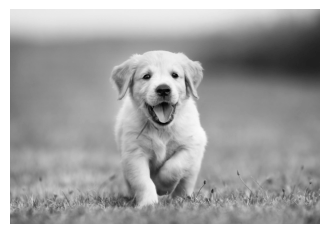

In [15]:
show_img(img_grey.cpu(), cmap='gray')

### Float

In [16]:
img_grey.zero_()
for i in range(1000): module.rgb_to_grayscale(imgc,  img_grey, 1, False)
for i in range(10): module.rgb_to_grayscale(imgc,  img_grey, 1, True)
assert_equal(img_grey_gs, img_grey.cpu())

elTime (ns): 30.88
elTime (ns): 30.72
elTime (ns): 30.59
elTime (ns): 30.66
elTime (ns): 30.72
elTime (ns): 30.46
elTime (ns): 30.59
elTime (ns): 29.70
elTime (ns): 29.70
elTime (ns): 30.62


## Int

In [17]:
img_grey.zero_()
for i in range(1000): module.rgb_to_grayscale(imgc,  img_grey, 2, False)
for i in range(10): module.rgb_to_grayscale(imgc,  img_grey, 2, True)
assert_equal(img_grey_gs, img_grey.cpu())

elTime (ns): 31.74
elTime (ns): 33.79
elTime (ns): 30.72
elTime (ns): 30.72
elTime (ns): 30.72
elTime (ns): 29.70
elTime (ns): 29.70
elTime (ns): 29.70
elTime (ns): 29.50
elTime (ns): 29.70


## Float with coalesced uint reads/writes

In [18]:
img_grey.zero_()
for i in range(1000): module.rgb_to_grayscale(imgc,  img_grey, 3, False)
for i in range(10): module.rgb_to_grayscale(imgc,  img_grey, 3, True)
assert_equal(img_grey_gs, img_grey.cpu())

elTime (ns): 27.84
elTime (ns): 27.65
elTime (ns): 27.84
elTime (ns): 27.62
elTime (ns): 27.65
elTime (ns): 26.98
elTime (ns): 27.65
elTime (ns): 27.36
elTime (ns): 26.78
elTime (ns): 27.65


## Float with vectorized coaleced uint2 reads/writes

In [19]:
img_grey.zero_()
for i in range(1000): module.rgb_to_grayscale(imgc,  img_grey, 4, False)
for i in range(10): module.rgb_to_grayscale(imgc,  img_grey, 4, True)
assert_equal(img_grey_gs, img_grey.cpu())

elTime (ns): 27.65
elTime (ns): 27.65
elTime (ns): 26.62
elTime (ns): 27.65
elTime (ns): 28.58
elTime (ns): 26.62
elTime (ns): 27.42
elTime (ns): 27.65
elTime (ns): 27.65
elTime (ns): 27.65


## Memory transfer cost - coalesced reads/writes of R plane

In [20]:
img_grey.zero_()
for i in range(1000): module.rgb_to_grayscale(imgc,  img_grey, 5, False)
for i in range(10): module.rgb_to_grayscale(imgc,  img_grey, 5, True)
assert_equal(img[0,:,:], img_grey.cpu())

elTime (ns): 12.29
elTime (ns): 12.32
elTime (ns): 12.29
elTime (ns): 12.29
elTime (ns): 12.29
elTime (ns): 12.48
elTime (ns): 12.10
elTime (ns): 12.29
elTime (ns): 11.26
elTime (ns): 13.15


## Float calc with vectorized reads/writes using cub

In [21]:
img_grey.zero_()
for i in range(1000): module.rgb_to_grayscale(imgc,  img_grey, 6, False)
for i in range(10): module.rgb_to_grayscale(imgc,  img_grey, 6, True)
assert_equal(img_grey_gs, img_grey.cpu())

elTime (ns): 26.62
elTime (ns): 27.65
elTime (ns): 27.55
elTime (ns): 27.52
elTime (ns): 27.65
elTime (ns): 26.62
elTime (ns): 27.65
elTime (ns): 27.65
elTime (ns): 27.46
elTime (ns): 27.65
